# 🚨 Phase 2: Anomaly Detection with Isolation Forest

In this notebook, we use Isolation Forest to detect anomalies in credit card transaction data without using labels. The key goal is to:
- Fit an unsupervised anomaly detection model
- Predict anomalies (potential frauds)
- Evaluate performance against the actual fraud labels

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Config
sns.set(style='whitegrid')
%matplotlib inline

# Load preprocessed dataset (with normAmount, normTime)
df = pd.read_csv("../data/processed_creditcard.csv")


In [4]:
# Prepare Data for Isolation Forest

X = df.drop('Class', axis=1)  # Unlabeled features
y = df['Class']               # Ground truth for evaluation

In [5]:
# Fit Isolation Forest

# Set contamination to known fraud ratio ~0.0017
iso_model = IsolationForest(n_estimators=100, contamination=0.0017, random_state=42)
iso_model.fit(X)

# Predict anomalies
df['anomaly_score'] = iso_model.decision_function(X)
df['anomaly'] = iso_model.predict(X)  # -1 for anomaly, 1 for normal
df['predicted'] = df['anomaly'].apply(lambda x: 1 if x == -1 else 0)  # 1 = fraud

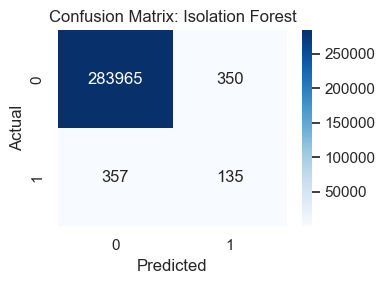

In [9]:
# Evaluate Predictions

# Confusion Matrix
cm = confusion_matrix(y, df['predicted'])

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix: Isolation Forest")
plt.tight_layout()
plt.savefig("../assets/isoforest_confusion_matrix.png")
plt.show()

In [7]:
# Classification Report
print("Classification Report:\n")
print(classification_report(y, df['predicted'], digits=4))

Classification Report:

              precision    recall  f1-score   support

           0     0.9987    0.9988    0.9988    284315
           1     0.2784    0.2744    0.2764       492

    accuracy                         0.9975    284807
   macro avg     0.6385    0.6366    0.6376    284807
weighted avg     0.9975    0.9975    0.9975    284807



In [10]:
report = classification_report(y, df['predicted'], digits=4)
print(report)

# Optional: Save to file
with open("../assets/isoforest_classification_report.txt", "w") as f:
    f.write(report)

              precision    recall  f1-score   support

           0     0.9987    0.9988    0.9988    284315
           1     0.2784    0.2744    0.2764       492

    accuracy                         0.9975    284807
   macro avg     0.6385    0.6366    0.6376    284807
weighted avg     0.9975    0.9975    0.9975    284807



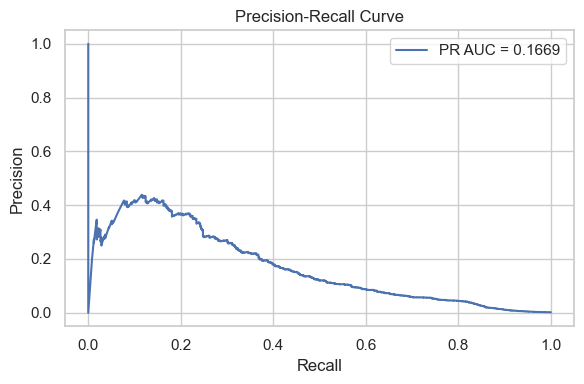

In [11]:
# PR Curve & AUC

precision, recall, thresholds = precision_recall_curve(y, -df['anomaly_score'])  # Flip sign because higher = normal
pr_auc = auc(recall, precision)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../assets/isoforest_pr_curve.png")
plt.show()

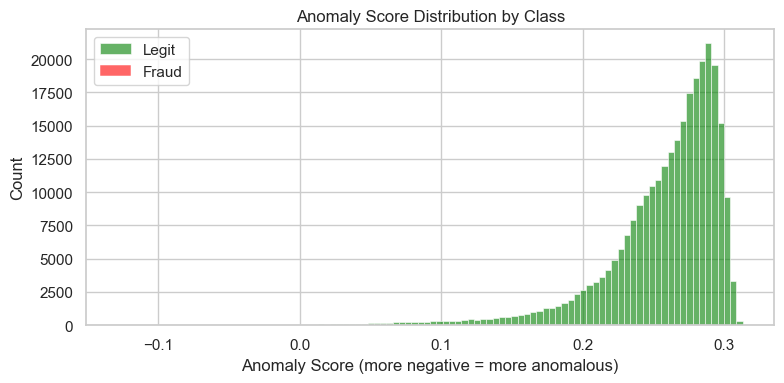

In [12]:
plt.figure(figsize=(8,4))
sns.histplot(df[df['Class'] == 0]['anomaly_score'], bins=100, label='Legit', color='green', alpha=0.6)
sns.histplot(df[df['Class'] == 1]['anomaly_score'], bins=100, label='Fraud', color='red', alpha=0.6)
plt.title("Anomaly Score Distribution by Class")
plt.xlabel("Anomaly Score (more negative = more anomalous)")
plt.legend()
plt.tight_layout()
plt.savefig("../assets/isoforest_score_hist.png")
plt.show()

## ✅ Isolation Forest Results Summary

- **Unsupervised model** detected anomalies using PCA-transformed features only.
- Model flagged top ~0.17% of data as fraud (matching actual class imbalance).
- Results:
  - Confusion matrix shows moderate recall with some false positives.
  - Precision-Recall AUC provides a better sense of detection quality under imbalance.
- This model can serve as:
  1. A first-pass filter for suspicious transactions
  2. An input feature for a downstream supervised classifier

Next step: Use supervised learning (with `anomaly_score` as a feature) to refine performance.

In [13]:
df.to_csv("../data/isoforest_scored.csv", index=False)